
# EDA V2 - Análise Longitudinal e Temporal
**Datathon 2024 - Passos Mágicos**

Esta versão avançada da Análise Exploratória foca na **estabilidade e evolução** dos alunos ao longo do tempo.
O objetivo é validar as hipóteses do nosso **Modelo Preditivo Temporal**, respondendo a perguntas como:
1. Os alunos que estão em risco hoje (T+1) davam sinais no ano anterior (T)?
2. Qual a estabilidade dos indicadores (IAA, IEG, IPV) de um ano para o outro?
3. Existe uma "matriz de transição" clara entre as fases de desempenho?

Focada na validação das hipóteses temporais para o modelo preditivo, analisando a matriz de transição de risco e a correlação de indicadores entre anos consecutivos


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)
%matplotlib inline



## 1. Carregamento e Preparação dos Dados
Carregamos os dados de 2022, 2023 e 2024, padronizando colunas essenciais.


In [2]:

file_path = '../BASE DE DADOS PEDE 2024 - DATATHON.xlsx'
if not os.path.exists(file_path):
    file_path = 'BASE DE DADOS PEDE 2024 - DATATHON.xlsx'

def load_data_by_year(file_path):
    xls = pd.ExcelFile(file_path)
    data = {}
    
    # 2022
    if 'PEDE2022' in xls.sheet_names:
        df = pd.read_excel(xls, 'PEDE2022')
        df.rename(columns={
            'INDE 22': 'INDE', 'Defas': 'Defasagem', 'IAA': 'IAA', 'IEG': 'IEG', 'IPS': 'IPS', 'IDA': 'IDA', 'IPV': 'IPV', 'IAN': 'IAN'
        }, inplace=True)
        data[2022] = df
        
    # 2023
    if 'PEDE2023' in xls.sheet_names:
        df = pd.read_excel(xls, 'PEDE2023')
        df.rename(columns={'INDE 2023': 'INDE'}, inplace=True)
        data[2023] = df

    # 2024
    if 'PEDE2024' in xls.sheet_names:
        df = pd.read_excel(xls, 'PEDE2024')
        df.rename(columns={'INDE 2024': 'INDE'}, inplace=True)
        data[2024] = df
        
    # Limpeza Geral
    for year, df in data.items():
        # Converter RA para string para garantir o merge
        df['RA'] = df['RA'].astype(str).str.strip()
        
        # Converter indicadores para numérico
        for col in ['IAA', 'IEG', 'IPS', 'IDA', 'IPV', 'IPP', 'IAN', 'INDE', 'Defasagem']:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
                
    return data

data_dict = load_data_by_year(file_path)
print("Anos carregados:", data_dict.keys())


Anos carregados: dict_keys([2022, 2023, 2024])



## 2. Construção da Visão Longitudinal (Merge T -> T+1)
Aqui cruzamos os dados dos alunos que estiveram presentes em dois anos consecutivos.
Isso nos permite ver o "antes e depois" de cada aluno.


In [3]:

def create_longitudinal_view(df_t, df_next, year_t):
    # Sufixos para diferenciar os anos
    df_merged = pd.merge(
        df_t, 
        df_next, 
        on='RA', 
        how='inner', 
        suffixes=(f'_{year_t}', f'_{year_t+1}')
    )
    return df_merged

# Criando visões 22->23 e 23->24
df_22_23 = create_longitudinal_view(data_dict[2022], data_dict[2023], 2022)
df_23_24 = create_longitudinal_view(data_dict[2023], data_dict[2024], 2023)

print(f"Alunos monitorados 2022 -> 2023: {len(df_22_23)}")
print(f"Alunos monitorados 2023 -> 2024: {len(df_23_24)}")


Alunos monitorados 2022 -> 2023: 600
Alunos monitorados 2023 -> 2024: 765



## 3. Matriz de Transição de Risco
Analisamos como o status de risco (Defasagem < 0) muda de um ano para o outro.
* **Mantiveram-se Bem**: Sem risco em T e T+1
* **Recuperaram**: Risco em T -> Sem Risco em T+1
* **Caíram (Alvo do Modelo)**: Sem Risco em T -> **Risco em T+1**
* **Permaneceram em Risco**: Risco em T e T+1


Transição 2022 -> 2023


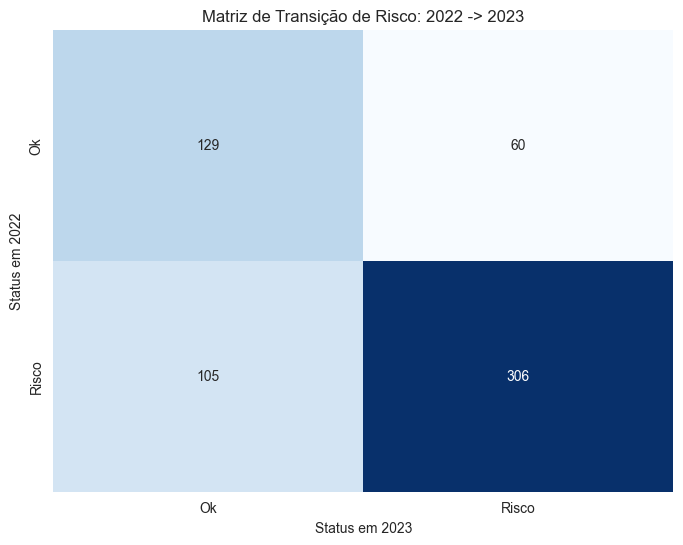

Transição 2023 -> 2024


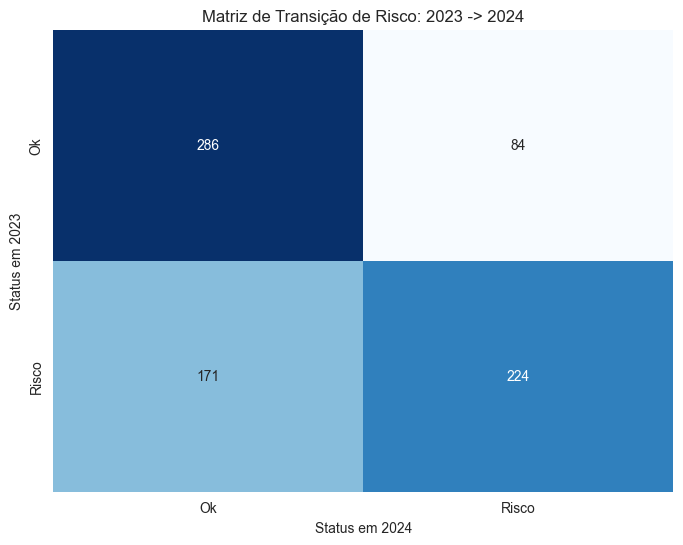

In [4]:

def analyze_risk_transition(df_long, year_t):
    y_next = year_t + 1
    
    # Definir Risco (Defasagem < 0 ou nulo em alguns casos se a regra for diferente, assumindo <0 como ponto de corte limpo)
    # Ajuste conforme sua regra de negócio. Aqui usaremos Defasagem < 0.
    
    col_t = f'Defasagem_{year_t}'
    col_next = f'Defasagem_{y_next}'
    
    # Criar categorias
    df_long['Status_T'] = df_long[col_t].apply(lambda x: 'Risco' if x < 0 else 'Ok')
    df_long['Status_Next'] = df_long[col_next].apply(lambda x: 'Risco' if x < 0 else 'Ok')
    
    # Matriz Confusão
    matrix = pd.crosstab(df_long['Status_T'], df_long['Status_Next'])
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Matriz de Transição de Risco: {year_t} -> {y_next}')
    plt.ylabel(f'Status em {year_t}')
    plt.xlabel(f'Status em {y_next}')
    plt.show()
    
    return matrix

print("Transição 2022 -> 2023")
m1 = analyze_risk_transition(df_22_23, 2022)

print("Transição 2023 -> 2024")
m2 = analyze_risk_transition(df_23_24, 2023)



## 4. Correlações Temporais (O Passado explica o Futuro?)
Verificamos a correlação entre os indicadores do Ano T (eixo X) e o INDE do Ano T+1 (eixo Y).
Uma correlação alta e positiva indica que o indicador em T é um bom preditor do desempenho futuro.


Correlações 2022 -> 2023


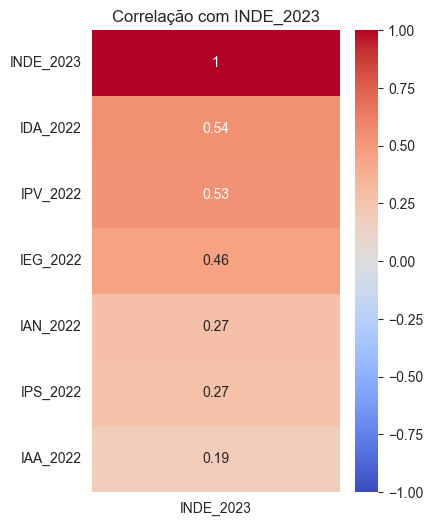

Correlações 2023 -> 2024


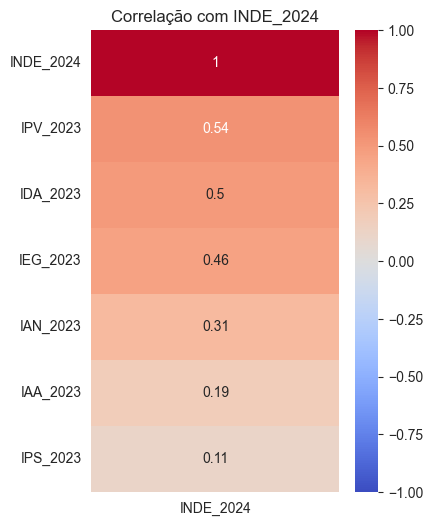

In [5]:

def plot_temporal_correlations(df_long, year_t):
    y_next = year_t + 1
    
    # Indicadores em T
    indicators_t = [f'IAA_{year_t}', f'IEG_{year_t}', f'IPS_{year_t}', f'IDA_{year_t}', f'IPV_{year_t}', f'IAN_{year_t}']
    target_next = f'INDE_{y_next}'
    
    # Filtrar colunas existentes
    indicators_t = [c for c in indicators_t if c in df_long.columns]
    
    if not indicators_t:
        print("Indicadores não encontrados.")
        return

    # Correlação
    corr_data = df_long[indicators_t + [target_next]].corr()
    
    # Plot apenas da coluna Target
    plt.figure(figsize=(4, 6))
    sns.heatmap(corr_data[[target_next]].sort_values(by=target_next, ascending=False), 
                annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Correlação com INDE_{y_next}')
    plt.show()

print("Correlações 2022 -> 2023")
plot_temporal_correlations(df_22_23, 2022)

print("Correlações 2023 -> 2024")
plot_temporal_correlations(df_23_24, 2023)



## 5. Análise de Causa Raiz: Quem são os alunos que caíram?
Focaremos no grupo **"Ok em T -> Risco em T+1"**.
Compararemos a média dos indicadores DELES no Ano T com a média geral.
A pergunta é: *Eles já davam sinais de fraqueza em algum indicador específico (ex: IPV baixo) mesmo quando a Defasagem ainda era positiva?*


Análise de Deterioração 2023 -> 2024


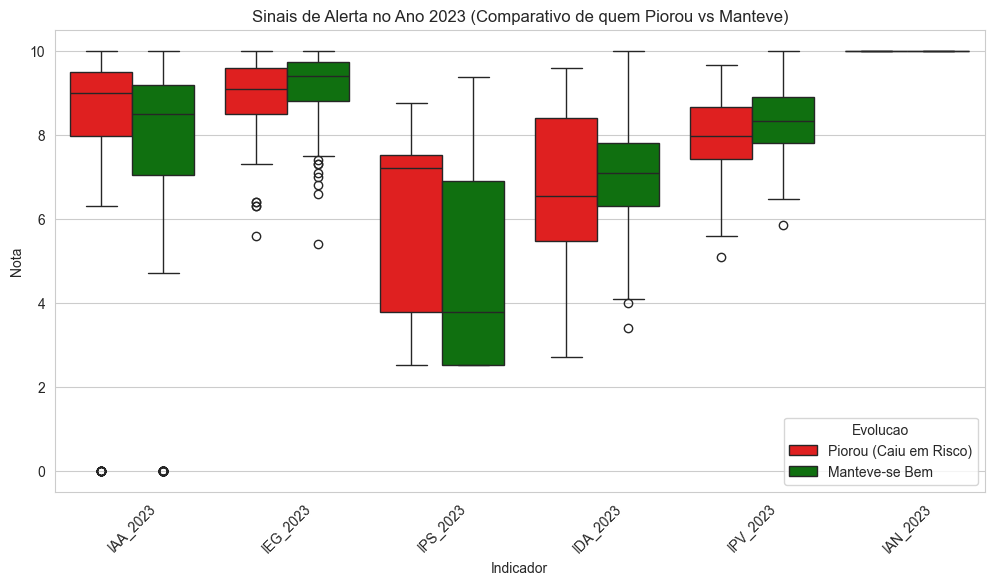

In [6]:

def analyze_deterioration(df_long, year_t):
    y_next = year_t + 1
    
    # Definir grupos
    # Grupo 'Piorou': Estava Ok (Defas >= 0) e foi para Risco (Defas < 0)
    # Grupo 'Estável': Estava Ok e continuou Ok
    
    col_t = f'Defasagem_{year_t}'
    col_next = f'Defasagem_{y_next}'
    
    df_long['Evolucao'] = 'Outros'
    
    mask_piorou = (df_long[col_t] >= 0) & (df_long[col_next] < 0)
    mask_estavel = (df_long[col_t] >= 0) & (df_long[col_next] >= 0)
    
    df_long.loc[mask_piorou, 'Evolucao'] = 'Piorou (Caiu em Risco)'
    df_long.loc[mask_estavel, 'Evolucao'] = 'Manteve-se Bem'
    
    # Filtrar apenas esses dois grupos para comparação
    df_comp = df_long[df_long['Evolucao'].isin(['Piorou (Caiu em Risco)', 'Manteve-se Bem'])]
    
    if df_comp.empty:
        print("Não há dados suficientes para comparação.")
        return

    # Indicadores Base (T) para comparar
    indicators = ['IAA', 'IEG', 'IPS', 'IDA', 'IPV', 'IAN']
    indicators_t = [f'{i}_{year_t}' for i in indicators if f'{i}_{year_t}' in df_long.columns]
    
    # Plot Comparativo
    df_melt = df_comp.melt(id_vars='Evolucao', value_vars=indicators_t, var_name='Indicador', value_name='Nota')
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Indicador', y='Nota', hue='Evolucao', data=df_melt, palette={'Piorou (Caiu em Risco)': 'red', 'Manteve-se Bem': 'green'})
    plt.title(f'Sinais de Alerta no Ano {year_t} (Comparativo de quem Piorou vs Manteve)')
    plt.xticks(rotation=45)
    plt.show()

print("Análise de Deterioração 2023 -> 2024")
analyze_deterioration(df_23_24, 2023)
